In [1]:
from salad.serialize import read, write
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
import astropy.units as u
from pathlib import Path
import astropy.table
import numpy as np

def load_summary(search_prefix, detector, snr, time_type, search_label, step="filtered"):
    # get recoveries at a certain step
    p = Path(f"/epyc/projects/salad/search/{search_prefix}/DEEP/20190403/A0c/detector_{detector}/snr_{snr}/{time_type}/{search_label}")
    return read(list(p.rglob(f"{step}_summary.pkl"))[0])


In [2]:
all_clusters = {}
for snr in [3.0]:
    for detector in range(1, 63):
        if detector in [2, 31, 61]:
            continue
        try:
            clusters = load_summary("new", detector, snr, "regular", "asteroid")
        except:
            print(snr, detector)
            continue
        for c in clusters:
            all_clusters[(detector, c)] = clusters[c]

In [3]:
from salad.deduplicate import deduplicate

In [4]:
cluster = all_clusters[next(iter(all_clusters.keys()))]

In [5]:
time_zero = cluster.summary['time'].min() * u.day
time_max = cluster.summary['time'].max() * u.day

In [6]:
time_zero

<Quantity 58577.21560552 d>

In [7]:
cluster.line.predict(time_zero)

<Quantity [[216.08736933, -11.07121083]] deg>

In [8]:
deduplicated, duplicates = deduplicate(
    all_clusters, time_zero, 
    5 * u.arcsec, 
    1 * u.arcsec/(time_max - time_zero)
)

In [9]:
len(deduplicated)

1260

In [10]:
duplicates

{(13, 819): (14, 491)}

In [14]:
all_clusters[(13, 819)].line.beta

<Quantity [[-0.21564472,  0.02835586]] deg / d>

In [15]:
all_clusters[(14, 491)].line.beta

<Quantity [[-0.21661047,  0.0280772 ]] deg / d>

In [11]:
len(all_clusters)

1261

In [18]:
velocity = []
for k in all_clusters:
    vx = all_clusters[k].line.beta[0, 0]
    vy = all_clusters[k].line.beta[0, 1]
    velocity.append(
        {
            "detector": k[0],
            "cluster": k[1],
            "vx": vx,
            "vy": vy,
        }
    )
velocity = astropy.table.Table(velocity)

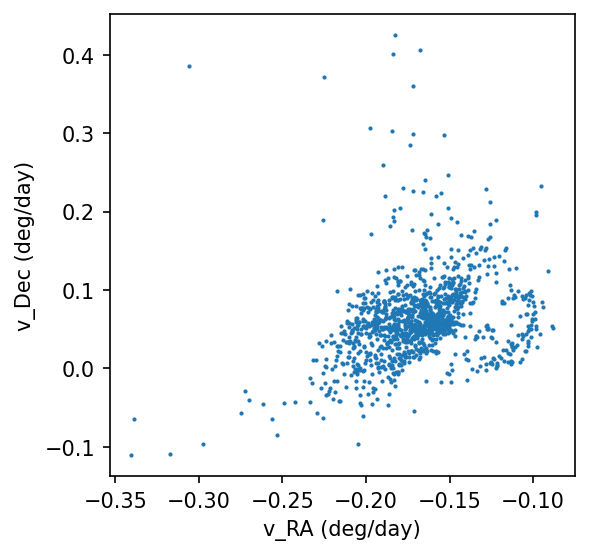

In [27]:
fig = plt.figure(dpi=150, figsize=[4, 4])
plt.scatter(velocity['vx'], velocity['vy'], s=1)
plt.xlabel("v_RA (deg/day)")
plt.ylabel("v_Dec (deg/day)")
plt.show()